https://github.com/shubhamchouksey/Consumer-Complaint-Classification/blob/master/ConsumerComplaintClassification.ipynb

## Libraries

In [73]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle
import math
import matplotlib.pyplot as plt
import string
import os
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing, linear_model, metrics, datasets, multiclass, svm
from itertools import cycle
from textblob import TextBlob
from textblob import Word
import seaborn as sns
import numpy.random as nr
import zipfile

## Exploratory Data Analysis

In [4]:
with zipfile.ZipFile('consumer_complaints.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
data=pd.read_csv('consumer_complaints.csv', encoding='latin-1')

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [7]:
data.head(10)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
5,08/30/2013,Credit card,NaN,Application processing delay,NaN,NaN,NaN,Capital One,NY,12206,NaN,NaN,Phone,09/03/2013,Closed with explanation,Yes,Yes,510098
6,08/30/2013,Credit card,NaN,Credit line increase/decrease,NaN,NaN,NaN,Wells Fargo & Company,AZ,85730,NaN,NaN,Postal mail,09/05/2013,Closed with explanation,Yes,No,511062
7,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Bank of America,IL,60660,NaN,NaN,Referral,09/04/2013,Closed with explanation,Yes,No,511116
8,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Bank of America,GA,30016,NaN,NaN,Referral,09/04/2013,Closed with explanation,Yes,No,511091
9,09/17/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",NaN,NaN,NaN,"SunTrust Banks, Inc.",CA,94551,NaN,NaN,Web,09/18/2013,Closed with explanation,Yes,Yes,530602


In the above data we have to just classify products based on narrative given by customers so, we need 2 column i.e. product and consumer_complaint_narrative

### Data Understanding

In [8]:
data.dtypes

date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                     int64
dtype: object

In [9]:
pd.notnull(data['consumer_complaint_narrative']).value_counts()

consumer_complaint_narrative
False    489151
True      66806
Name: count, dtype: int64

Take data which contain atleast 1 word which is to useful while model building. From the above output it shows 66806 are not null rows so we have to take onle those rows.

In [10]:
data=data[['product', 'consumer_complaint_narrative']]
data=data[pd.notnull(data['consumer_complaint_narrative'])]
data.head(10)

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n
190135,Consumer Loan,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in XXXX 2015, per my credit monitoring agency, it showed a delinquent balance of {$0.00}, but when I checked my credit report again on XXXX XXXX 2015, there was a delinquent balance of {$1400.00}. The monies from the GAP insurance and my insurance company has been paid, M & T Bank says that I still owe {$620.00}, of which {$210.00} has already been paid. I contacted M & T Bank via return receipt mail, but I have not been given the courtesy of a response yet. \n"
190155,Mortgage,"In XX/XX/XXXX my wages that I earned at my job decreased by almost half, by XX/XX/XXXX I knew I was in trouble with my home loan. I began contacting WFB whom my home loan is with, for assitance and options. \nIn early XX/XX/XXXX I began the Loan Modification process with Wells Fargo Bank. I was told that they would not assist me with anything financial on my home loan until I fell 90 days behind, though at the time I started to inquire for assistance from WFB I was only a few weeks behind. So, I began working with a program called XXXX. They approved me for a variety of assistence and reached out to Wells Fargo Bank to determine what they could assist with. Wells Fargo then turned down the assistance from XXXX and finally offered to do a Loan Modification for me. The outcome was totally unknow about what I would be offered in the end by WFB for assistance. Wells Fargo lost my paperwork twice during this process, so it took 2 months from the time I started to the time my paperwork began to be processed for some kind of approval. In XX/XX/XXXX I was in a trial period of 3 months of payments based on a slightly modified amount. Roughly {$75.00} less than what I was paying on my original payment. However, my caseworker with WFB, failed to tell me that since the payments during this time were not the full amount of the original mortgage payment so they were not applied to the loan. I discovered this in XX/XX/XXXX when I was told by a creditor with XXXX that she could n't restore my line of credit because of something to do with my mortgage. I then called and found this out. My caseworker at WFB then told me it was n't her responsibility to tell me this information. I told her that she could have told me that if I could come up with the remaining amount of {$75.00} then the payments would be applied. Instead, she chose to withhold this information and damage my credit even further. Now we are into 5 months ( including the 90 days WFB told me I had to fall behind until they would help me ) without an applied payment to my home loan, going on 6 months. \nMore paperwork was lost in XXXX as the modification was being finalized and my loan modification did n't go through until XX/XX/XXXX. I spoke to a lawyer that is working on a class-action laws

In [11]:
data.shape

(66806, 2)

Check the distribution of complaint by category

In [12]:
data.groupby('product').consumer_complaint_narrative.count()

product
Bank account or service     5711
Consumer Loan               3678
Credit card                 7929
Credit reporting           12526
Debt collection            17552
Money transfers              666
Mortgage                   14919
Other financial service      110
Payday loan                  726
Prepaid card                 861
Student loan                2128
Name: consumer_complaint_narrative, dtype: int64

__Note__: Imbalance Dataset. Other financial service, Money transfers, Payday loan, Prepaid card are having less than 1000 rows denoting imbalance dataset.<br><br>
Let's Analyse it graphically.

### Splitting the data

<function matplotlib.pyplot.show(close=None, block=None)>

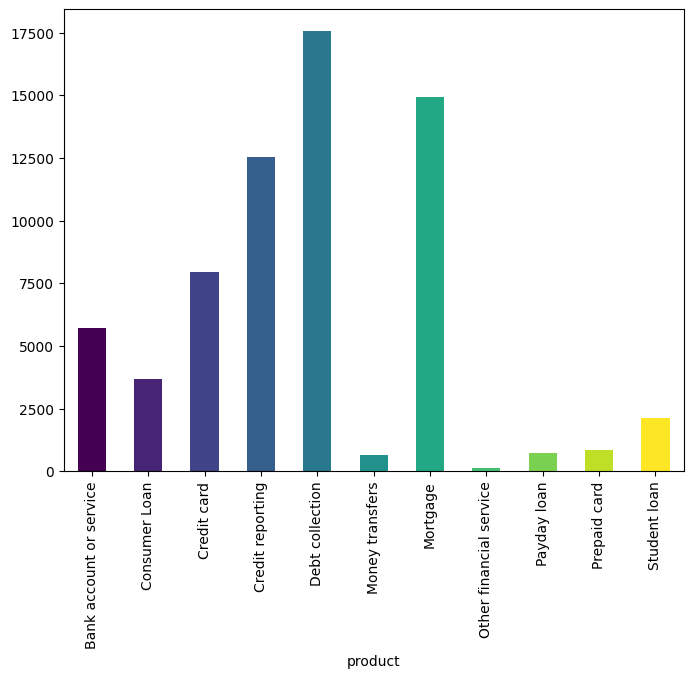

In [13]:
fig=plt.figure(figsize=(8, 6))
colormap = plt.cm.viridis
uniquevalues_product=data['product'].unique()
data.groupby('product').consumer_complaint_narrative.count().plot.bar(color=colormap(np.linspace(0, 1, len(uniquevalues_product))))
plt.show

## Converting Text to Features
The procedure of converting raw text data into machine understandable format (numbers) is called feature engineering of text data. Machine learning and deep learning algorithm performance and accuracy is fundamentally dependent on the type of feature engineering techniques uses.
### TF_IDF Vectorizer
TF_IDF is the most applied feature engineering technique for processing textual kind data by many machine learning expert and data scientist.<br><br>
- __Term Frequency (TF)__: Term frequency is simply the ratio of the count of a word present in a sentence, to the lenght of the sentence. TF is basically capturing the importance of the word irrespective of the length of the document. Ex: a word with the frequence of 3 with the length of sentence being 10 is not the same as when the word length of sentence being 100 words. It should get more importance in the first scenario; that is what TF does.
- __Inverse Document Frequency (IDF)__: IDF of each word is the log of the ratio of the total number or rows to the number of rows in a particular document in which that word is present. IDF will measure the rareness of a term, word like 'a' and 'the' show up in all the documents of corpus, but the rave words is not in all the documents. TF-IDF is the simplest product of TF and IDF so that both of the drawbacks are addressed, which makes predictions and information retrieval relevant.

In [14]:
tfidf_vect=TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)
'''
default {max_df=1.0(float) so its proportion of word contain in all documents,
simply if a words contain in all the document it is 1.0}, {min_df=1(int) 
so iteger directly denotes count of words in a document shows atleast 1 word 
contains in a documents then only it is consider}
'''
tfidf_vect.fit(data['consumer_complaint_narrative'])
features=tfidf_vect.transform(data['consumer_complaint_narrative'])

encoder=preprocessing.LabelEncoder()
labels1=encoder.fit_transform(data['product'])

# Binarize the output
# labels=np.array(preprocessing.label.binarize(labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))

In [15]:
print(features[0], labels1)

  (0, 4980)	0.19946692590518458
  (0, 4967)	0.08367785689944471
  (0, 4528)	0.03945843468300431
  (0, 4486)	0.05079420833765883
  (0, 4475)	0.05074380583274784
  (0, 4466)	0.20886092796068428
  (0, 4464)	0.08214182747432149
  (0, 4462)	0.04046932892633899
  (0, 4290)	0.13501006475169727
  (0, 4063)	0.08953356522886974
  (0, 3495)	0.13173594877936717
  (0, 3270)	0.08506969605084602
  (0, 3229)	0.0916469670914765
  (0, 3210)	0.24774356329679265
  (0, 3115)	0.046174555519359825
  (0, 2845)	0.05348433820104951
  (0, 2518)	0.2246454974653814
  (0, 2449)	0.23373093275704698
  (0, 2326)	0.2000394496046405
  (0, 2305)	0.10983925924295175
  (0, 2215)	0.07212388567496104
  (0, 2200)	0.18464139378136915
  (0, 2031)	0.20026770337237787
  (0, 1994)	0.15112095802707426
  (0, 1457)	0.1633685106412558
  (0, 1199)	0.13429597623199974
  (0, 1056)	0.10694069345312737
  (0, 1011)	0.1716552590907946
  (0, 977)	0.11978819231338515
  (0, 881)	0.20696270632845382
  (0, 878)	0.08642368937977245
  (0, 762)	0.12

Next, exevute the code in the cell below to split the dataset into test and training set. Notice that usually, 25% of the 100% cases are being used as teh test dataset.

In [16]:
train_X, valid_X, train_y, valid_y=train_test_split(data['consumer_complaint_narrative'], data['product'])

In [17]:
train_X

224951                                                                                                                 Green Tree collection agency is reporting that we owe them {$400000.00} on a XXXX purchase money loan. They have sent us a letter saying that we do n't owe them the money, but refuse to stop reporting it to credit reporting agencies. This is preventing us the opportunity of refinancing our home. We have been working to get this resolved since late last year ( 2014 ). \n
303221                                                            Select Portfolio Servicing ( SPS ) has now contact family member in attempt to harass me for a mortgage loan that was dismissed by a judge. I have made prior complaints on SPS for leaving notes and taking pictures of my property every month on Saturdays, but now they are calling my relative in attempt to humiliate me more. I want SPS to stop with harassing tactics and leave my family and relatives alone. Please advise, \n
501396          

In [18]:
encoder=preprocessing.LabelEncoder()
train_y=encoder.fit_transform(train_y)
valid_y=encoder.fit_transform(valid_y)
print(train_y)

[4 6 3 ... 1 4 2]


In [19]:
tfidf_vect=TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)
'''
Default {max_df=1.0(float) so its proportion of word contain in all documents,
simply if a words contain in all the document it is 1.0}, {min_df=1(int) so 
iteger directly denotes count of words in a document shows atleast 1 word 
contains in a documents then only it is consider}
'''
tfidf_vect.fit(data['consumer_complaint_narrative'])
print(tfidf_vect.stop_words_)

{'15the', 'wherechanging', '200k', 'chokepoint', 'soybeans', 'plantation', 'ofsuch', 'sanding', '18month', 'annunitys', '5563', 'threshold', 'halls', 'deceives', 'cohen', 'supportingdocumentation', 'beadded', 'wasmislead', 'frecuent', 'butts', 'sweaters', 'interjected', 'syrchrony', 'analyized', 'resulf', 'controllers', 'clsoing', 'brent', 'remic', 'sdaid', 'deter', 'withno', 'remarkably', 'handy', 'attributes', 'circumvent', 'itxx', 'doublewide', 'seeingnext', '2015tried', '2924g', 'deafult', 'vouched', 'invited', 'siituation', 'rewardspoints', 'shaved', 'bare', 'declaimer', 'hereyear', 'correctged', 'commession', 'recordsthank', 'unwiling', '77000', 'retiered', 'transuion', 'papas', 'missasigned', 'disregarding', 'gestures', 'veriiedy', 'accountrepresentative', 'bkr', 'reallocate', 'retransmission', 'translation', 'moneyusing', 'ofconsideration', 'ue', 'rmb', 'depost', 'anyhone', '90min', 'againstautovest', 'donor', 'leasee', 'thatnationstar', 'stumble', 'waggins', 'governmentinsured

In [20]:
print(tfidf_vect.vocabulary_)

{'xxxx': 4967, 'has': 2215, 'claimed': 1011, 'i': 2326, 'owe': 3210, 'them': 4466, '27': 108, '00': 1, 'for': 1994, 'years': 4980, 'despite': 1457, 'the': 4462, 'proof': 3495, 'of': 3115, 'payment': 3270, 'sent': 4063, 'canceled': 881, 'check': 977, 'and': 486, 'their': 4464, 'invoice': 2518, 'they': 4475, 'continue': 1199, 'to': 4528, 'insist': 2449, 'collection': 1056, 'agencies': 420, 'are': 562, 'after': 413, 'me': 2845, 'how': 2305, 'can': 878, 'stop': 4290, 'this': 4486, 'harassment': 2200, 'a': 274, 'bill': 762, 'already': 463, 'paid': 3229, 'four': 2031, 'ago': 426, 'due': 1610, 'in': 2373, 'amount': 479, 'owed': 3211, 'that': 4460, 'was': 4836, 'told': 4531, 'by': 858, 'm': 2771, 't': 4404, 'bank': 686, 'reported': 3797, 'credit': 1285, 'reporting': 3798, 'advised': 392, 'write': 4954, 'good': 2129, 'will': 4895, 'letter': 2663, 'order': 3166, 'address': 359, 'issue': 2533, 'request': 3815, 'negative': 3019, 'entry': 1720, 'be': 714, 'removed': 3764, 'from': 2052, 'my': 2992, 

In [21]:
Xtrain_tfidf=tfidf_vect.transform(train_X)
# print(Xtrain_tfidf)
Xvalid_tfidf=tfidf_vect.transform(valid_X)

In [22]:
help(TfidfVectorizer)

Help on class TfidfVectorizer in module sklearn.feature_extraction.text:

class TfidfVectorizer(CountVectorizer)
 |  TfidfVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
 |  
 |  Convert a collection of raw documents to a matrix of TF-IDF features.
 |  
 |  Equivalent to :class:`CountVectorizer` followed by
 |  :class:`TfidfTransformer`.
 |  
 |  For an example of usage, see
 |  :ref:`sphx_glr_auto_examples_text_plot_document_classification_20newsgroups.py`.
 |  
 |  For an efficiency comparision of the different feature extractors, see
 |  :ref:`sphx_glr_auto_examples_text_plot_hashing_vs_dict_vectorizer.py`.
 |  
 |  Read more in the :ref:`U

## Model Building
Suppose we are building a linear classifier on word-level TF-IDF vectors. We are using default hyper parameters for the classifier.

In [23]:
print(Xtrain_tfidf[0])

  (0, 4978)	0.11575612297085613
  (0, 4967)	0.04147761963990193
  (0, 4939)	0.14755726297282898
  (0, 4846)	0.289293896682797
  (0, 4712)	0.23459462494625827
  (0, 4587)	0.2044960053238586
  (0, 4528)	0.11735304937369362
  (0, 4486)	0.10071112867391467
  (0, 4475)	0.050305597093410245
  (0, 4466)	0.13803817718070185
  (0, 4462)	0.08023969515882325
  (0, 4460)	0.09417793049103708
  (0, 4404)	0.08252623983527933
  (0, 4290)	0.13384415712411943
  (0, 4144)	0.09380386207953864
  (0, 4063)	0.0887603794162671
  (0, 3986)	0.13327669815587392
  (0, 3847)	0.15570427976755927
  (0, 3798)	0.33155270718112345
  (0, 3693)	0.15285297979330703
  (0, 3681)	0.20311593735367722
  (0, 3534)	0.14629411590904373
  (0, 3428)	0.23184413570151666
  (0, 3210)	0.24560412198430775
  (0, 3182)	0.11130833490043575
  (0, 3157)	0.18969328269539776
  (0, 3139)	0.047665316911431034
  (0, 3115)	0.045775805495951956
  (0, 2994)	0.08312645032589157
  (0, 2957)	0.1988748016877744
  (0, 2720)	0.08498601765111043
  (0, 2663

In [24]:
model=linear_model.LogisticRegression().fit(Xtrain_tfidf, train_y)

In [25]:
model

LogisticRegression()

### Model Evaluation

In [26]:
def accuracy():
    # Checking accuracy
    accuracy=metrics.accuracy_score(model.predict(Xvalid_tfidf), valid_y)
    print(f"Accuracy: {np.round(accuracy, 5)}")
    print(metrics.classification_report(valid_y, model.predict(Xvalid_tfidf), 
                                        target_names=data['product'].unique()))

In [27]:
accuracy()

Accuracy: 0.84864
                         precision    recall  f1-score   support

        Debt collection       0.84      0.80      0.82      1409
          Consumer Loan       0.78      0.58      0.66       885
               Mortgage       0.81      0.81      0.81      1925
            Credit card       0.86      0.86      0.86      3221
       Credit reporting       0.81      0.90      0.85      4393
           Student loan       0.79      0.50      0.62       143
Bank account or service       0.92      0.95      0.94      3773
            Payday loan       0.00      0.00      0.00        17
        Money transfers       0.62      0.30      0.40       171
Other financial service       0.81      0.62      0.70       217
           Prepaid card       0.88      0.76      0.81       548

               accuracy                           0.85     16702
              macro avg       0.74      0.64      0.68     16702
           weighted avg       0.85      0.85      0.84     16702



Examine these results:
1. The overall accuracy is 0.847. However as just observed this is as somewhat misleading becuase of some cases like money transfer, payday loan, and other financial service are little misclassified.
2. The class imbalance is confirmed. Of the 33, 190, 210 cases are very elss than as compaire to 4370 or 3700.
3. The precision, recall and F1 all show that Debt collection, MOrtgage, Credit card, Credit reporting, Bank account or service, Prepaid card cases are classified reasonably well, but the Consumer Loan, Student loan, Payday loan, Money transfers, Other financial service cases are not. As if those categories are misclassified is will directly cost to bank, because after going complaint to unecpected team they will not able to resolve the issues and ticket is going to send to appropriate team so, increases time range and directly impacts to customer satisfaction leads to high risk on customes relationship mangement by bank, since bakn fully depends on customers they should not tollerate it.<br><br>

Let's Analyse the correctly classified and misclassified data closely by heatmap structure and confusion matrix.

In [28]:
def heat_conf():
    # confusion matrix
    conf_mat=metrics.confusion_matrix(valid_y, model.predict(Xvalid_tfidf))
    print(conf_mat)
    print('='*80)
    '''
    # visualizing confusion matrix
    category_id_df=data[['product', 'category_id']].drop_duplicates().sort_values('category_id')
    category_id_df
    '''
    fig, ax=plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', 
                xticklabels=data['product'].unique(), 
                yticklabels=data['product'].unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

[[1132   10  111   27   39    5   60    0    0   25    0]
 [  25  509   56   67  148    1   64    0   11    1    3]
 [  66   10 1566   79  176    6   18    0    0    3    1]
 [   8   21   71 2755  302    0   51    0    1    0   12]
 [  21   47   65  185 3940    4   75    0   19    0   37]
 [  35    1    8    4   14   72    6    0    0    3    0]
 [  22   15   13   56   67    0 3600    0    0    0    0]
 [   5    0    1    2    5    0    1    0    0    0    3]
 [   9   28    3    8   64    1    7    0   51    0    0]
 [  30    0   40    1    7    2    2    0    0  135    0]
 [   1   12    4   16   75    0   26    0    0    0  414]]


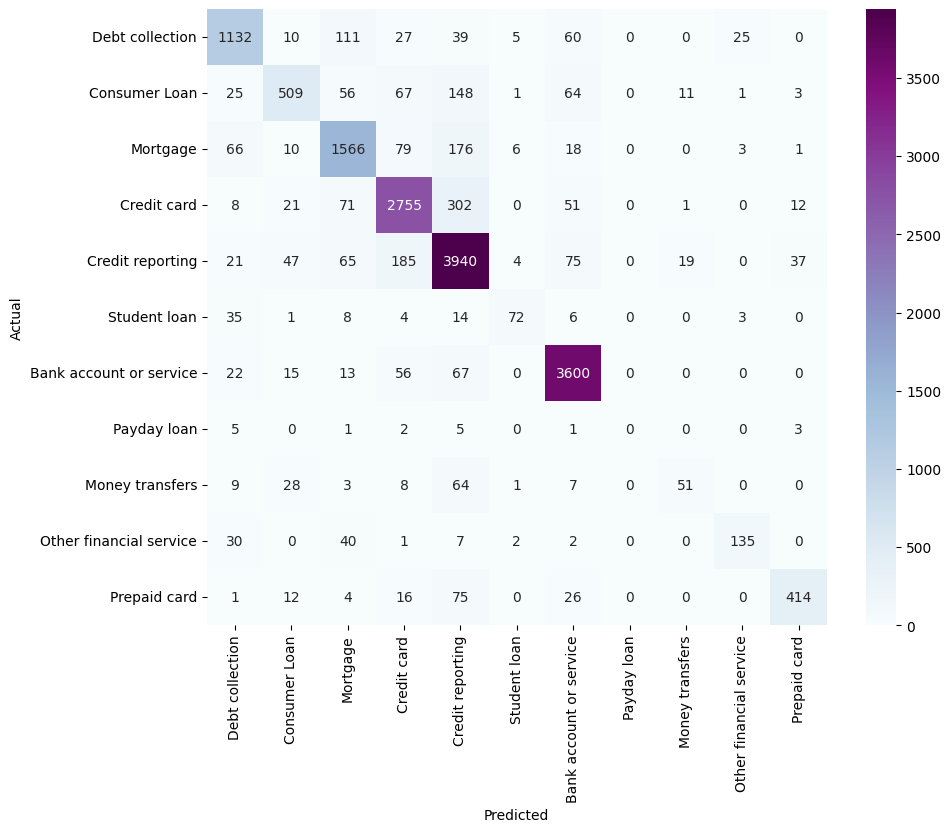

In [29]:
heat_conf()

Examine the result:<br>
The confussion matrix shows the following characteristics: a) Debt collection, Mortage, Credit card, Consumer Loan, Credit reporting, Bank account or service, Prepaid card cases are classified reasonably well, b) but the Student loan, Paydar loan, Money transfers, Other financial service cases are not however.

In [30]:
category_id_df=pd.DataFrame()
category_id_df['category']=data['product'].unique()
category_id_df['category_id']=category_id_df.index.values

#print(category_id_df.index.values)
category_to_id=dict(category_id_df[['category_id', 'category']].values)
category_to_id

{0: 'Debt collection',
 1: 'Consumer Loan',
 2: 'Mortgage',
 3: 'Credit card',
 4: 'Credit reporting',
 5: 'Student loan',
 6: 'Bank account or service',
 7: 'Payday loan',
 8: 'Money transfers',
 9: 'Other financial service',
 10: 'Prepaid card'}

In [31]:
probabilities=model.predict_proba(Xvalid_tfidf)
print(probabilities[:15, :])

[[4.08056112e-03 8.27506600e-02 1.59058022e-01 5.52890441e-01
  1.83548474e-01 4.88845839e-04 1.29804460e-02 8.93844089e-04
  1.25918014e-03 2.70109166e-04 1.77941780e-03]
 [6.64851381e-05 7.76980750e-04 9.90699525e-04 1.58405509e-04
  9.96079560e-01 3.25185498e-05 1.36488998e-04 3.15116488e-05
  1.27066820e-03 5.69320742e-05 3.99749315e-04]
 [4.06683724e-02 1.68374629e-02 2.81507278e-02 8.69136833e-02
  8.31205894e-02 6.11633154e-01 4.39900339e-02 1.28741836e-02
  2.03799554e-02 3.96106220e-02 1.58212155e-02]
 [2.32028552e-02 4.07703766e-03 9.23242803e-01 1.67434039e-02
  8.95042390e-03 1.09803408e-03 5.62247284e-03 5.77041960e-04
  5.93810697e-04 1.46209039e-02 1.27121299e-03]
 [2.26265664e-02 5.75643541e-02 6.90348833e-01 5.43848033e-03
  1.32413455e-01 4.08430560e-03 7.30389118e-02 1.76527397e-03
  5.19990135e-03 3.12288782e-03 4.39703101e-03]
 [5.93370816e-03 2.20369568e-02 2.22444561e-02 1.82745103e-03
  9.03203785e-01 3.20921916e-03 2.03249434e-03 1.08205915e-03
  1.28568127e-02

The above shows probabilitic approach towards the classification problem, where the highest prob belongs to the particular class. for ex: see the 1st row it belongs to class 7, its value range [0-1]<br><br>
Now the below code shows that The decision_function() tells us on which side of the hyperplane generated by the classifier we are (and how far we are away from it). Based on that information, the estimator then label the examples with the corresponding label.

In [32]:
y_score=model.decision_function(Xvalid_tfidf)
print(y_score[:15, :])

[[-0.74397497  2.26562251  2.91905957  4.16495039  3.06226932 -2.86591757
   0.4132346  -2.26243339 -1.91974865 -3.45913856 -1.57392324]
 [-1.77174453  0.68669261  0.92968832 -0.90356471  7.84285945 -2.48691228
  -1.05247896 -2.51836569  1.17857521 -1.92686409  0.02211467]
 [-0.01838193 -0.90022629 -0.38625942  0.74108285  0.69645981  2.69230005
   0.06013048 -1.16860859 -0.70928079 -0.04473532 -0.96248084]
 [ 1.32073667 -0.41816801  5.00435359  0.99446572  0.36816223 -1.73001729
  -0.09676709 -2.37337896 -2.34473337  0.85891361 -1.58356711]
 [ 0.31699458  1.25077339  3.73506689 -1.10863047  2.08379912 -1.39497841
   1.4888622  -2.23382424 -1.15349048 -1.66337198 -1.3212006 ]
 [-0.41581865  0.89625291  0.90562483 -1.59354587  4.60948022 -1.03044033
  -1.48720421 -2.11760215  0.35740585 -1.03591273  0.91176013]
 [ 0.41016159  0.19191011  0.29419999 -0.46740222  0.655454   -0.88531025
   7.25495515 -2.4911895  -1.98928031 -2.98833591  0.01483735]
 [ 0.08138996  0.56522957  0.66184163  2.

In [33]:
predictions=model.predict(Xvalid_tfidf)
print(predictions[:15])

[3 4 5 2 2 4 6 3 6 3 3 9 6 6 3]


Binarize the output

In [34]:
y=preprocessing.label_binarize(valid_y, classes=[0,1,2,3,4,5,6,7,8,9,10])
n_classes=y.shape[1]
y

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

Finally, the code in the cell bellow computes and displays the ROC curve and AUC. The roc_curve and auc functions from the scikit-learn metrics package are used to compute these values.

In [35]:
def plot_auc(labels, colours=['orange']):
    
    # Compute ROC curve and ROC area for each class
    n_classes=len(category_to_id)
    #print(n_classes)
    fpr=dict()
    tpr=dict()
    roc_auc=dict()
    
    # Compute the false positive rate, true positive rate
    # and threshold along with the AUC
    
    for i in range(n_classes):
        fpr[i], tpr[i], _=metrics.roc_curve(y[:,i], y_score[:,i])
        #print(fpr[i], tpr[i])
        roc_auc[i]=metrics.auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 6))
    for i, color in zip(range(n_classes), colours):
        plt.plot(fpr[i], tpr[i], color=color, label='AUC of class {0} = {1:0.2f}'.format(i, roc_auc[i]))
    
    # Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel("False Positive Rate")
    plt.show()

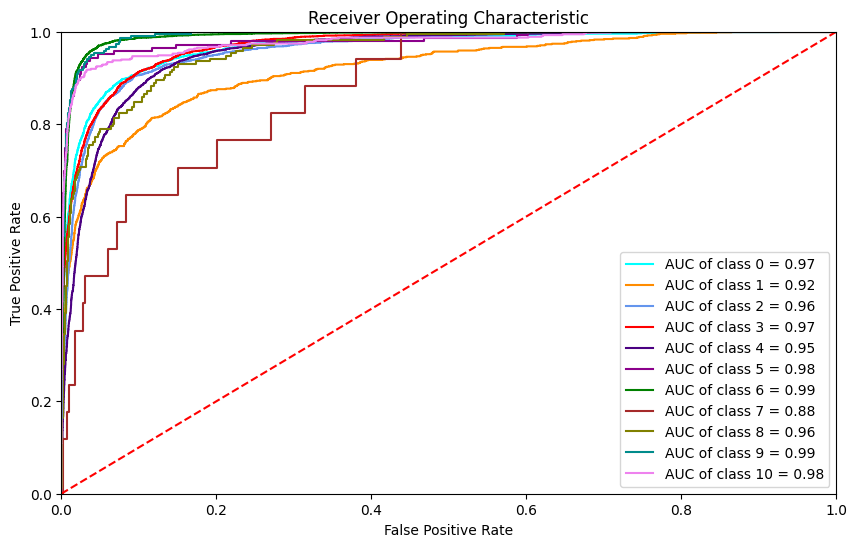

In [36]:
colours = ['aqua', 'darkorange', 'cornflowerblue','r','indigo',
           'darkmagenta','green','brown','olive','darkcyan','violet']
# in place of probabilities we can put y_score of decision function as well. 
# we will get a same 
plot_auc(y, colours)

The above graph if for all the classified ROC curves with different colors. Legends show that all the auc are much higher and well correctly classified sonsumer complaints, mostly values are above 0.95 excepting some for 0.91. This curves shows that we have build a perdectly nice model as expected which is mostly classified correct complaints.

### Compute a weighted model
Recall that a falsely classifying a some categorical product customer as different category, cost high to bank and followup time to customers increases. Given this situation, the results of the first model are not that good. There are two reasons for this:<br><br>
1. The class imbalance in the label has bissed the training of the model.
2. Nothing has been done to weight the results toward correctly classifying particular product category data.<br><br>

One approcah to these problemas is to weight the classes when computing the logistic regression model. The code in the cell bellow adds a class_weight argument to the call to the LogisticRegression function. In this case weights are chosen as 5 for class 5 and 10 for class 7 but you can also give another combinations. Execute this code.<br><br>
__Note__: default class_weights are 1.

In [37]:
# result_metric = metrics.precision_recall_fscore_support(train_y,model.predict(xtrain_tfidf))
# num_cases = result_metric[3][:]
# print(num_cases.sort())
# print(sum(num_cases))
# label_dic = {i:j for i,j in zip(num_cases,range(len(num_cases)))}
# print(label_dic)
# perc = []
# for i in range(len(num_cases)):
#     perc.append(num_cases[i]/sum(num_cases))
# perc_rev = sorted(perc,reverse=True)
# num_cases.sort()
# #print(perc_rev)
# class_weights = {label_dic[i]:j for i,j in zip(num_cases,perc_rev)}

# print(class_weights)

In [38]:
Counter(train_y)

Counter({4: 13159,
         6: 11146,
         3: 9305,
         2: 6004,
         0: 4302,
         1: 2793,
         10: 1580,
         9: 644,
         8: 555,
         5: 523,
         7: 93})

In [39]:
model=linear_model.LogisticRegression(class_weight={8:3.0, 9:3, 5:3.0, 7:20}).fit(Xtrain_tfidf, train_y)
model

LogisticRegression(class_weight={5: 3.0, 7: 20, 8: 3.0, 9: 3})

In [40]:
accuracy()

Accuracy: 0.84846
                         precision    recall  f1-score   support

        Debt collection       0.86      0.78      0.81      1409
          Consumer Loan       0.81      0.56      0.66       885
               Mortgage       0.82      0.81      0.81      1925
            Credit card       0.86      0.86      0.86      3221
       Credit reporting       0.82      0.89      0.85      4393
           Student loan       0.62      0.72      0.66       143
Bank account or service       0.92      0.95      0.94      3773
            Payday loan       0.16      0.24      0.19        17
        Money transfers       0.51      0.56      0.53       171
Other financial service       0.78      0.76      0.77       217
           Prepaid card       0.89      0.76      0.82       548

               accuracy                           0.85     16702
              macro avg       0.73      0.72      0.72     16702
           weighted avg       0.85      0.85      0.85     16702



[[1092    9  103   29   40   31   56   12    3   34    0]
 [  24  493   53   71  144    4   62    0   30    1    3]
 [  67    9 1552   81  171   16   18    1    1    9    0]
 [   9   21   68 2760  300    0   50    0    2    0   11]
 [  23   42   71  192 3900    5   76    3   44    0   37]
 [  13    1    4    3    9  103    5    1    1    3    0]
 [  21   15   13   57   68    2 3591    2    4    0    0]
 [   3    0    1    1    3    1    1    4    1    0    2]
 [   8   12    1    7   41    1    5    1   95    0    0]
 [  13    0   27    1    6    4    0    0    0  166    0]
 [   2   10    4   16   73    0   22    1    5    0  415]]


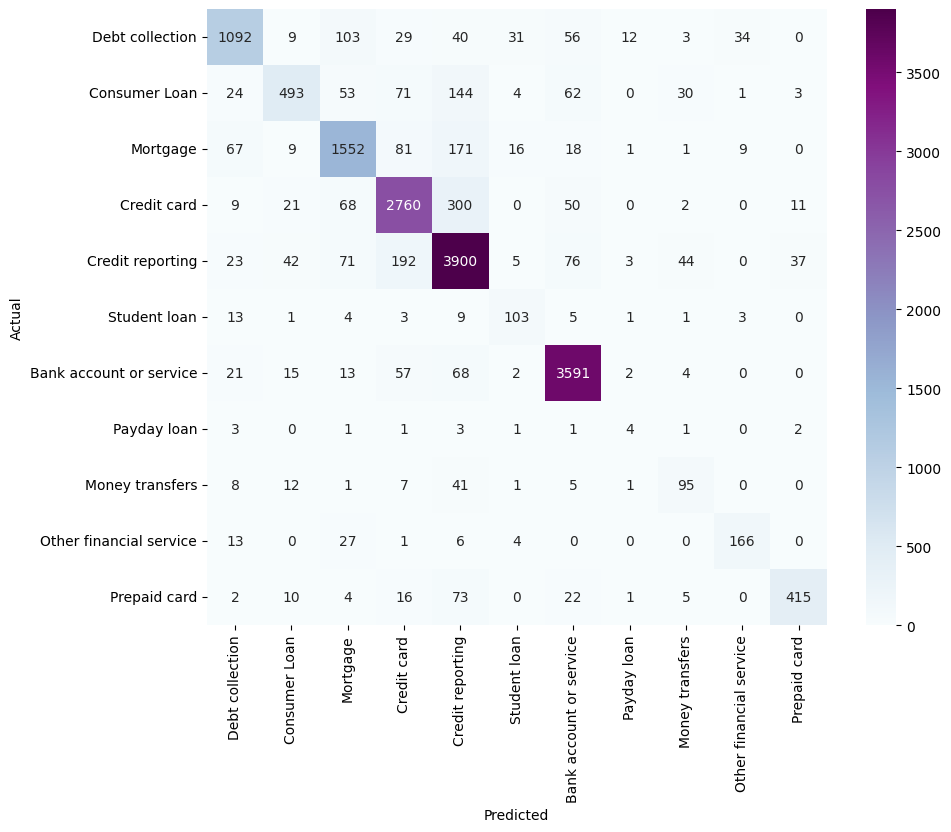

In [41]:
heat_conf()

In [42]:
y_score=model.decision_function(Xvalid_tfidf)
print(y_score[:15, :])

[[-0.94194275  2.21866803  2.84807858  4.16666363  3.02052512 -3.08378824
   0.41954616 -1.02859737 -1.9442309  -3.99533738 -1.67958488]
 [-2.03507859  0.55723494  0.81102421 -0.93609469  7.72837871 -2.52124459
  -1.15654633 -2.00712001  1.81669333 -2.15578232 -0.10146466]
 [-0.41364686 -1.30961877 -0.74189815  0.34160078  0.23244352  3.69363188
  -0.49005874 -0.4297954  -0.11709361  0.60813125 -1.3736959 ]
 [ 1.19099006 -0.48403385  4.89788254  0.99221782  0.39388144 -1.52452998
  -0.14518461 -2.72961248 -2.63194301  1.80317657 -1.76284448]
 [ 0.22726253  1.09155154  3.55534854 -1.1517046   1.98204141 -1.32620176
   1.46310116 -1.68292979 -1.08055578 -1.61472434 -1.4631889 ]
 [-0.64710883  0.67044431  0.54169302 -1.95222422  4.0733969  -1.12062371
  -1.76272806 -0.55866405  1.02335463 -0.9378083   0.67026832]
 [ 0.19453904 -0.04353324  0.1336381  -0.54661624  0.6110164  -0.41371901
   7.19472749 -2.41425688 -1.48811224 -3.10903962 -0.1186438 ]
 [-0.08412453  0.37991995  0.55214043  2.

In [43]:
predictions=model.predict(Xvalid_tfidf)
print(predictions[:15])

[3 4 5 2 2 4 6 3 6 3 3 9 6 6 3]


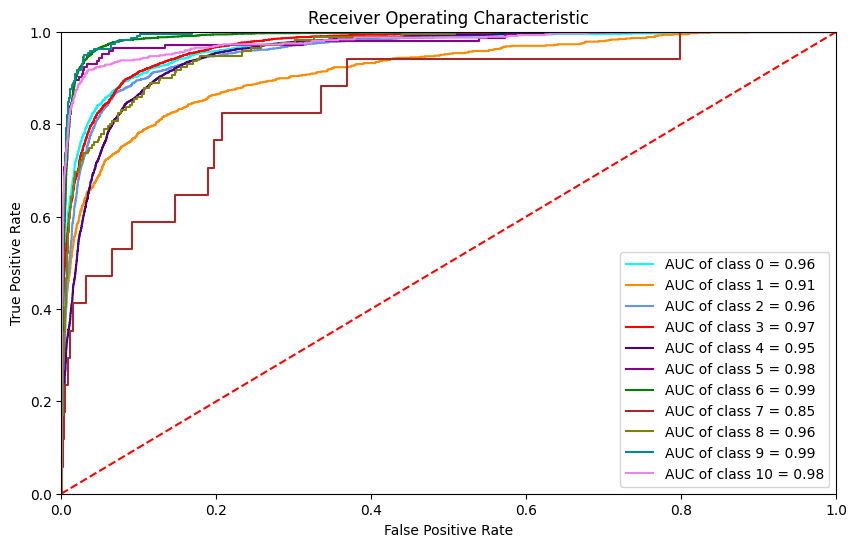

In [44]:
# in place of probabilities we can put y_score of decision function as well. 
# We will get a same result.
plot_auc(y, colours)

The accuracy is slightly changed with respect to the unweighted model. The change could be more had we give more weights to Payday loan, Money Transfers, Other financial services of the class than what we did here. The precision, recall and F1 are slightly better for the these cases. Reweighting the labels has moved the results in the desired direction, at least a bit.<br><br>
The trade-off between true positive and false positive is similar to the unweighted model.

In [45]:
texts=['This account popped up on my credit and it is not mines. I have filled out all the correct docs to show that i am victim of identity thief and will attach the ftc report with this complaint. Please block and remove this from my credit please XXXX XXXX XXXX Account Number: XXXX XXXX / 2019']
text_features=tfidf_vect.transform(texts)
predictions=model.predict(text_features)
#print(predictions)
print(texts)
print("\n\t -Predicted as: {}".format(category_to_id[predictions[0]]))

['This account popped up on my credit and it is not mines. I have filled out all the correct docs to show that i am victim of identity thief and will attach the ftc report with this complaint. Please block and remove this from my credit please XXXX XXXX XXXX Account Number: XXXX XXXX / 2019']

	 -Predicted as: Credit card


### Cross validate model
To compute a better estimate of model perfromance, you can perform simple cross validation. The code in the cell performs the following processing:
1. Create a list of the metrics to be computed for each fold.
2. Defines a logistic regression model object.
3. A 10 fold cross validation is performed using the cross_validate function from the scikit-learn model_selection package.<br><br>

Execute the following code.

In [46]:
#Labels = Labels.reshape(Labels.shape[0])
# Binarize the output
#Labels = preprocessing.label_binarize(Labels, classes=[0,1,2,3,4,5,6,7,8,9,10])
#Labels = np.array(Labels)
print(labels1)

[4 1 6 ... 8 6 6]


In [47]:
scoring=['precision_macro', 'recall_macro']
logistic_mod=linear_model.LogisticRegression(C=1.0, class_weight = {8:3.0, 9:3, 5:3.0, 7:20})
scores=ms.cross_validate(logistic_mod, features, labels1, scoring=scoring,
                         cv=10, return_train_score=False)

The code in the cell bellow displays the preformance metrics along with the mean and standard deviation, computed for each fold to the cross validation. The 'macro' versions of precision and recall are used. These macro versions average over the all the multinomial cases.

In [48]:
def print_format(f,x,y):
    print("Fold  %2d        %4.3f          %4.3f"%(f,x,y))

def print_cv(scores):
    fold=[x+1 for x in range(len(scores['test_precision_macro']))]
    print("              Precision       Recall")
    [print_format(f,x,y) for f,x,y in zip(fold, scores['test_precision_macro'],
                                          scores['test_recall_macro'])]
    
    print("-"*40)
    print('Mean            %4.3f          %4.3f '%
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro'])))  
    print('Std             %4.3f          %4.3f '%
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro'])))

In [49]:
print_cv(scores)

              Precision       Recall
Fold   1        0.717          0.682
Fold   2        0.712          0.676
Fold   3        0.732          0.691
Fold   4        0.729          0.713
Fold   5        0.745          0.738
Fold   6        0.762          0.747
Fold   7        0.786          0.755
Fold   8        0.753          0.750
Fold   9        0.734          0.748
Fold  10        0.744          0.722
----------------------------------------
Mean            0.742          0.722 
Std             0.021          0.029 


NOtice that there is considerable variability in each of the performance metrics from fold to fold. Even so, the standard deviations are at least an order of magnitude than the means. It is clear that __any one fold does not provide a representative value of the performance metrics__. The later is a key point as to why cross validation is important when evaluating a machine learning model.<br><br>
Compare the preformance metric values to the values obtained for the baseline model you created above. In general the metrics obtained by cross validation are lower. However, the metrics obtained for the baselin model are within 1 standard deviaton of the average metrics from cross validation.
#### Optimize hyperparameters with nested cross validation
The variability observed in cross-validation highlights the uncertainty of performing model selection based on a single training and evaluation. Fortunately, the nested cross-validation approach offers a more reliable method for model selection. However, there's no guarantee that model selection will improve a model; in some cases, it may have minimal impact.<br><br>
To initiate the nested cross-validation process, it's necessary to define randomly sampled folds for the inner and outer loops. The provided code below utilizes the KFolds function from the scikit-learn model_selection package to define fold selection objects. Notably, the shuffle=True argument ensures a random shuffle before creating folds, thereby guaranteeing independent sampling for both inner and outer loops. Importantly, the creation of independent fold objects eliminates the need for explicitly creating nested loops in this process.<br><br>
Execute this code.

In [50]:
nr.seed(456)
inside=ms.KFold(n_splits=10, shuffle=True)
nr.seed(645)
outside=ms.KFold(n_splits=10, shuffle=True)

In model selection searches, an important decision revolves around selecting the appropriate performance metric to identify the best model. For classification problems, scikit-learn defaults to using accuracy as the metric. However, as previously observed, accuracy may not be optimal, especially in the presence of class imbalance, as in this case. There are several alternative metrics suitable for such situations. In this instance, AUC (Area Under the Curve) will be utilized.<br><br>
The provided code executes the inner loop of the nested cross-validation using the inside k-fold object. The steps are as follows:<br><br>
1. Define a dictionary containing the grid of parameter values to search over. In this scenario, only one parameter, C, is included with a list of values to try. In more complex cases, the dictionary can encompass values from multiple parameters, forming a multidimensional grid for the cross-validation process to iterate through. In this specific case, there are 5 hyperparameter values in the grid, and 10-fold cross-validation is applied, resulting in the model being trained and evaluated 50 times.
2. Define the logistic regression model object.
3. Perform cross-validation search over the parameter grid using the GridSearch function from the scikit-learn model_selection package. Notably, the cross-validation folds are computed using the inside k-fold object.<br><br>
__Note__: Somewhat confusingly, the scikit-learn LogisticRegression funciton uses a regularization parameter $C$ which is the inverse of the sual l2 regularization parameter $\lambda$. Thus, the smaller the parameter the stronger the regulation.<br><br>
Execute this code.

In [58]:
nr.seed(3456)

# Define the dictionary for the grid search and the model object to search on
param_grid={"estimator__C":[0.1, 1, 10, 100, 1000]}
# Define the logisctic regression model
logistic_mod=linear_model.LogisticRegression()

clf_log=multiclass.OneVsRestClassifier(logistic_mod)

# Perform the grid search over the parameters
clf=ms.GridSearchCV(estimator=clf_log,
                    param_grid=param_grid,
                    cv=inside, # Use the inside folds
                    scoring='roc_auc',
                    return_train_score=True)

The cross validated grid search object, `clf`, has been created.<br><br>
The code in the cell below fits the cross validated modelusing the `fit` method. The AUC for each hyperparameter and fold id displayed as an array. Finally, the hyperparameter for the model with the best average AUC is displayed. Execute this code and examine the results.

In [59]:
# Fit the cross validated grid search over the data
labels=preprocessing.label_binarize(labels1, classes=[0,1,2,3,4,5,6,7,8,9,10])
print(labels)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [60]:
clf.fit(features, labels)
keys = list(clf.cv_results_.keys())
print(keys)

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimator__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score']


In [61]:
for key in keys[6:16]:
    print(clf.cv_results_[key])

[0.95952597 0.97027794 0.96856028 0.96048559 0.95717161]
[0.95957604 0.97113356 0.96994765 0.96360629 0.96003804]
[0.9603343  0.9690122  0.96824235 0.96098215 0.95713196]
[0.95734081 0.96777644 0.96804416 0.9615556  0.95836699]
[0.96261741 0.97292179 0.97233023 0.96246899 0.95819539]
[0.95101043 0.96451734 0.96867347 0.96222055 0.95904028]
[0.95594847 0.96683932 0.96473008 0.9542765  0.94940808]
[0.95000466 0.96196629 0.96723648 0.9629987  0.95866399]
[0.96241591 0.9736521  0.9725113  0.96293402 0.95789047]
[0.94806358 0.9598153  0.95803165 0.94843205 0.94305627]


In [62]:
# And print the best parameter value
clf.best_params_

{'estimator__C': 10}

The array of AUC metrics has dimensions 10 folds X hyperparameter values. As you might expect by now, there is considerable variation in the AUC from fold to fold for each hyperparamter value, or column.<br><br>
Evidently, the optimal hyperparameter values is 10.<br><br>
To help understand this behavior a bit more, the code in the cell below does the following:
1. Compute and display the man and standard deviation of the AUC for each hyperparameter value.
2. Plot the AUC values for each fold vs. the huperparameter values. The mean AUC for each hyperparameter values is shown with a red +.<br><br>

Execute this code and examine the results.

In [67]:
def plot_cv(clf, param_grid, param='estimator__C'):
    params=[x for x in param_grid[param]]
    
    keys=list(clf.cv_results_.keys())
    grid=np.array([clf.cv_results_[key] for key in keys[6: 16]])
    print(grid)
    print("="*70)
    means=np.mean(grid, axis=0)
    stds=np.std(grid, axis=0)
    print("Performance metrics by parameter")
    print("Parameter   Mean performance   STD performance")
    for x, y, z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params=[math.log10(x) for x in params]
    
    #print(params*grid.shape[0])
    plt.scatter(params*grid.shape[0], grid.flatten())
    p=plt.scatter(params, means, color='red', marker='+', s=300)
    plt.plot(params, np.transpose(grid))
    plt.title("Performance metric vs log parametr value\n from cross validation")
    plt.xlabel("Log hyperparameter value")
    plt.ylabel("Performance metric")

[[0.95952597 0.97027794 0.96856028 0.96048559 0.95717161]
 [0.95957604 0.97113356 0.96994765 0.96360629 0.96003804]
 [0.9603343  0.9690122  0.96824235 0.96098215 0.95713196]
 [0.95734081 0.96777644 0.96804416 0.9615556  0.95836699]
 [0.96261741 0.97292179 0.97233023 0.96246899 0.95819539]
 [0.95101043 0.96451734 0.96867347 0.96222055 0.95904028]
 [0.95594847 0.96683932 0.96473008 0.9542765  0.94940808]
 [0.95000466 0.96196629 0.96723648 0.9629987  0.95866399]
 [0.96241591 0.9736521  0.9725113  0.96293402 0.95789047]
 [0.94806358 0.9598153  0.95803165 0.94843205 0.94305627]]
Performance metrics by parameter
Parameter   Mean performance   STD performance
    0.10        0.95668            0.00500
    1.00        0.96779            0.00434
   10.00        0.96783            0.00393
  100.00        0.96000            0.00460
 1000.00        0.95590            0.00510


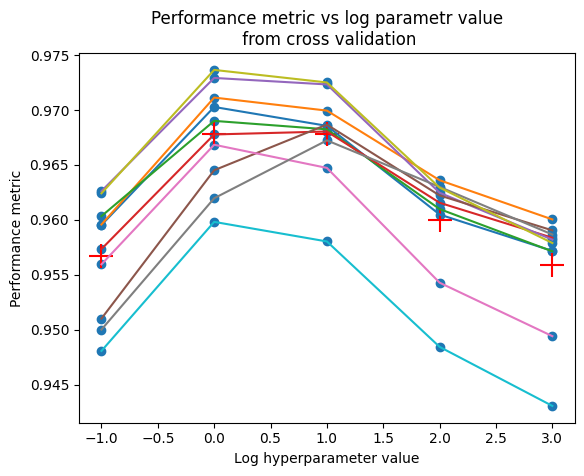

In [68]:
plot_cv(clf, param_grid)

There are a number of points to notice here:
1. The mean AUC for each of the hyperparameter are all within 1 standard deviation of each other. This result indicates that model performance is not sensitive to the choice of hyperparameter.
2. Graphically you can see that there is a noticeable variation in the AUC from metric to metric, regardless of hyperparameter. Keep in mind that __this variation is simply a result of random sampling of the data!__
Finally, it is time to try execute the outer loop of the nested cross validation toe valuate the performance of the 'best' model selected by the inner loop. In this case, 'best' is quite approximate, since as already noted, the differences n performance between themodels is not significant.<br><br>
The code in the cell below executes the outer loop of the nested cross validation using the `cross_val_scores` function from the scikit-learn `model_selection` package. The folds are determined by the `outside` k-fold object. The mean and standard deviation of the AUC is printed along with the value estimated for each fold. Execute this code and examine the result.

In [70]:
nr.seed(498)
cv_estimate=cross_val_score(clf, features, labels, cv=outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcome by cv fold')

for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.967
SDT of the metric       = 0.005
Outcome by cv fold
Fold  1    0.970
Fold  2    0.967
Fold  3    0.974
Fold  4    0.966
Fold  5    0.973
Fold  6    0.970
Fold  7    0.959
Fold  8    0.971
Fold  9    0.959
Fold 10    0.964


As expected, there is considerable variation in AUC across the folds. However, all of these values are within 1 standard deviation of each other, and thus these differences cannot be considered significant.

Accuracy: 0.84637
                         precision    recall  f1-score   support

        Debt collection       0.83      0.79      0.81      1409
          Consumer Loan       0.72      0.60      0.65       885
               Mortgage       0.82      0.80      0.81      1925
            Credit card       0.86      0.86      0.86      3221
       Credit reporting       0.83      0.87      0.85      4393
           Student loan       0.61      0.70      0.65       143
Bank account or service       0.93      0.94      0.94      3773
            Payday loan       0.29      0.12      0.17        17
        Money transfers       0.48      0.54      0.51       171
Other financial service       0.75      0.75      0.75       217
           Prepaid card       0.88      0.80      0.84       548

               accuracy                           0.85     16702
              macro avg       0.73      0.71      0.71     16702
           weighted avg       0.85      0.85      0.85     16702

[[11

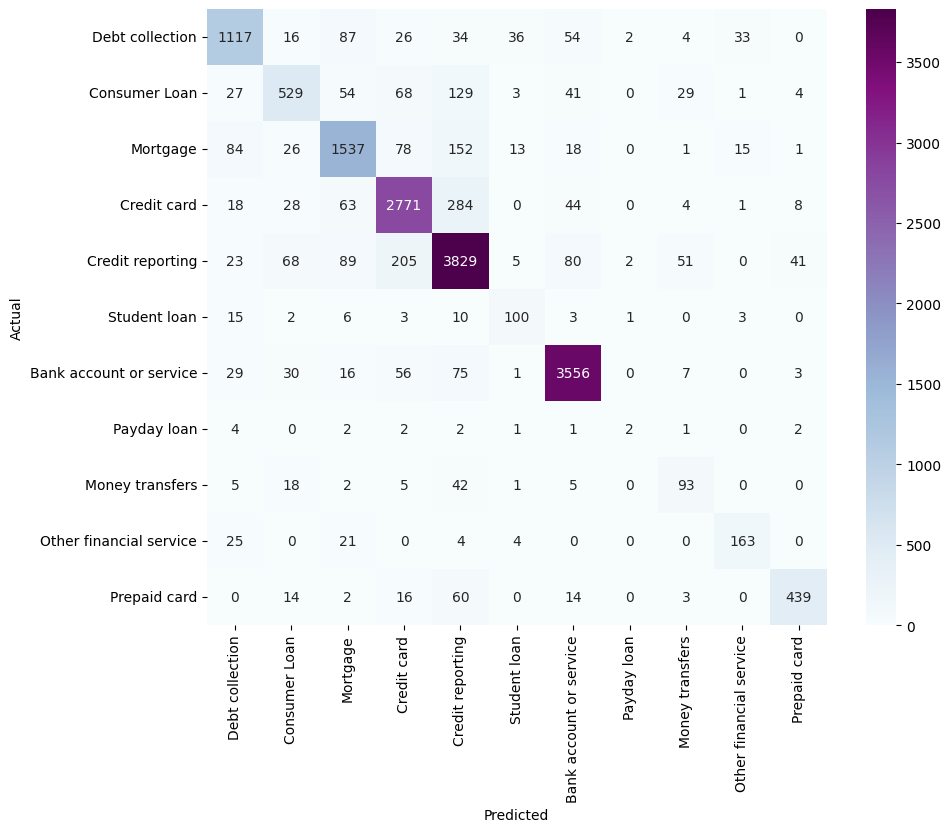

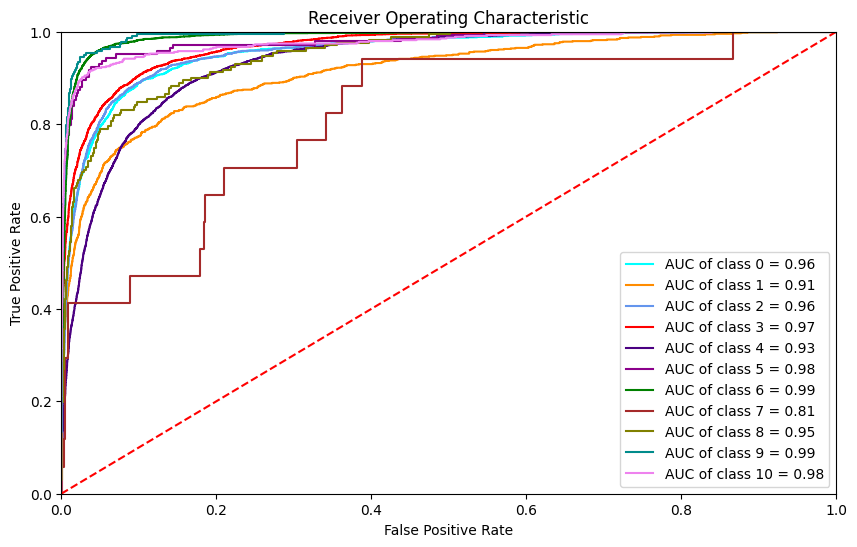

In [71]:
model=linear_model.LogisticRegression(C=10, class_weight={8:3.0, 9:3, 5:3.0, 7:20}).fit(Xtrain_tfidf, train_y)
accuracy()
heat_conf()
y_score=model.decision_function(Xvalid_tfidf)
#print(y_score[:15, :])
predictions=model.predict(Xvalid_tfidf)
#print(predictions[:15])

plot_auc(y, colours)

In [74]:
# open a file where lyou want to store the data
file=open('customer_classification_model_lr.pkl', 'wb')

# Dump imformation to that file
pickle.dump(model, file)

### Support Vector Machine Model
Nested cross validation is used to estimate the optimal hyperparameters and perfor model selection for the nonlinear SVM model. 5 fold cross calidation is used since training SVMs are computationally intensive to train. Additional folds would give better estimates but at the cost of greater computation time. Execute the code in the cell below to define inside and outside fold objects.

In [75]:
nr.seed(248)
inside=ms.KFold(n_splits=5, shuffle=True)

nr.seed(135)
outside=ms.KFold(n_splits=5, shuffle=True)

In [76]:
labels=preprocessing.label_binarize(labels1, classes=[0,1,2,3,4,5,6,7,8,9,10])
print(labels)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [77]:
nr.seed(3456)

# Define the dictionary for the grid search and the modelobject to search on
param_grid={"estimator__C":[1, 10, 100, 1000]}

# Define the SVM model
svc_clf=svm.LinearSVC()
svc_multi_clf=multiclass.OneVsRestClassifier(svc_clf)

# Perform the grid search over the parameters
clf=ms.GridSearchCV(estimator=svc_multi_clf,
                    param_grid=param_grid,
                    cv=inside, # use the inside folds
                    scoring='roc_auc',
                    return_train_score=True)

In [78]:
clf.fit(features, labels)
print(clf.best_params_)

{'estimator__C': 1}


[[0.96237425 0.95345318 0.94376585 0.93933104]
 [0.9640914  0.95496675 0.94500321 0.94036496]
 [0.96555233 0.95428558 0.94422557 0.93973713]
 [0.95734155 0.94535506 0.9344     0.929803  ]
 [0.95391437 0.94048582 0.92989161 0.92499845]
 [0.96065478 0.94970928 0.93945725 0.93484692]
 [0.00436265 0.0057729  0.00615038 0.00627541]
 [1.         2.         3.         4.        ]
 [0.99356322 0.99634593 0.99744053 0.99712382]
 [0.99351844 0.99634052 0.99742682 0.99707304]]
Performance metrics by parameter
Parameter   Mean performance   STD performance
    1.00        0.87554            0.29084
   10.00        0.96967            0.44662
  100.00        1.06378            0.70493
 1000.00        1.16096            0.98763


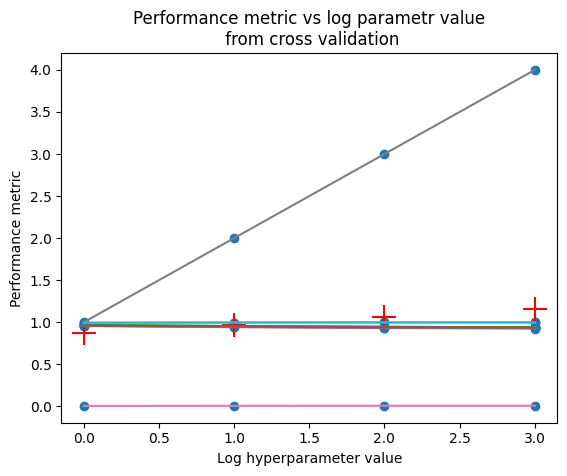

In [79]:
plot_cv(clf, param_grid)

In [80]:
nr.seed(498)
cv_estimate = cross_val_score(clf, features, labels, 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.960
SDT of the metric       = 0.005
Outcomes by cv fold
Fold  1    0.961
Fold  2    0.961
Fold  3    0.969
Fold  4    0.955
Fold  5    0.956


In [81]:
model=svm.LinearSVC(class_weight={8:3.0, 9:3, 5:3.0, 7:20}).fit(Xtrain_tfidf, train_y)

Accuracy: 0.8505
                         precision    recall  f1-score   support

        Debt collection       0.84      0.78      0.81      1409
          Consumer Loan       0.77      0.58      0.66       885
               Mortgage       0.81      0.81      0.81      1925
            Credit card       0.87      0.86      0.87      3221
       Credit reporting       0.83      0.88      0.86      4393
           Student loan       0.62      0.66      0.64       143
Bank account or service       0.93      0.95      0.94      3773
            Payday loan       0.33      0.18      0.23        17
        Money transfers       0.51      0.51      0.51       171
Other financial service       0.78      0.73      0.75       217
           Prepaid card       0.87      0.81      0.84       548

               accuracy                           0.85     16702
              macro avg       0.74      0.70      0.72     16702
           weighted avg       0.85      0.85      0.85     16702

[[109

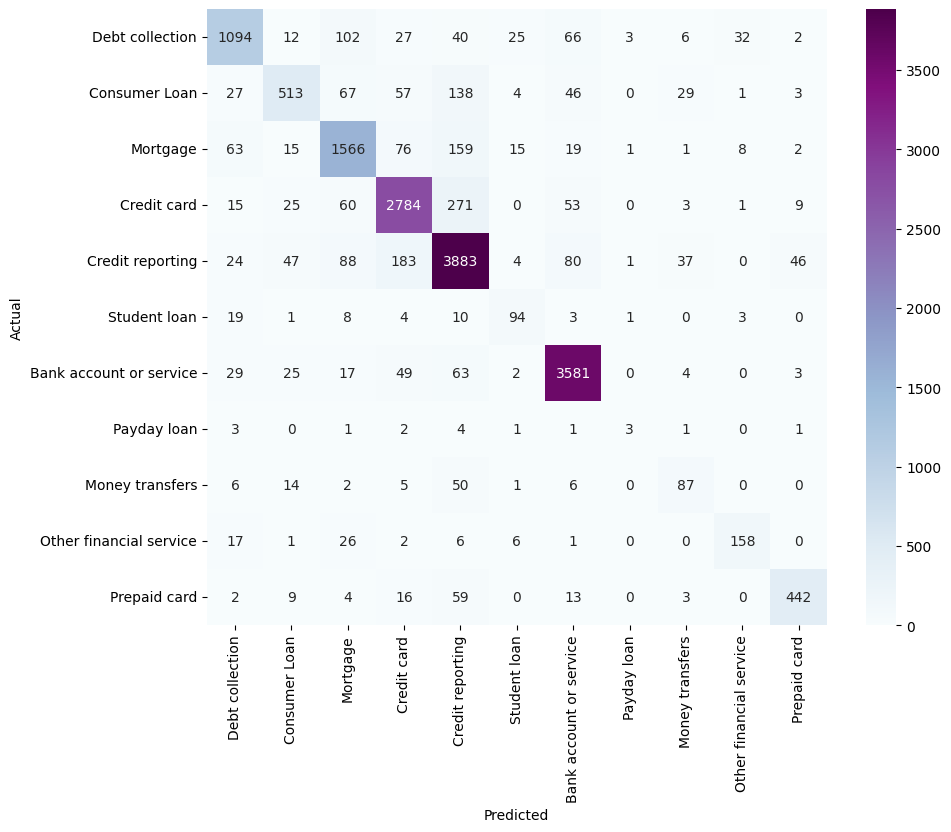

In [82]:
accuracy()
heat_conf()
y_score = model.decision_function(Xvalid_tfidf)
# print(y_score[:15,:])
predictions = model.predict(Xvalid_tfidf)
# print(predictions[:15])

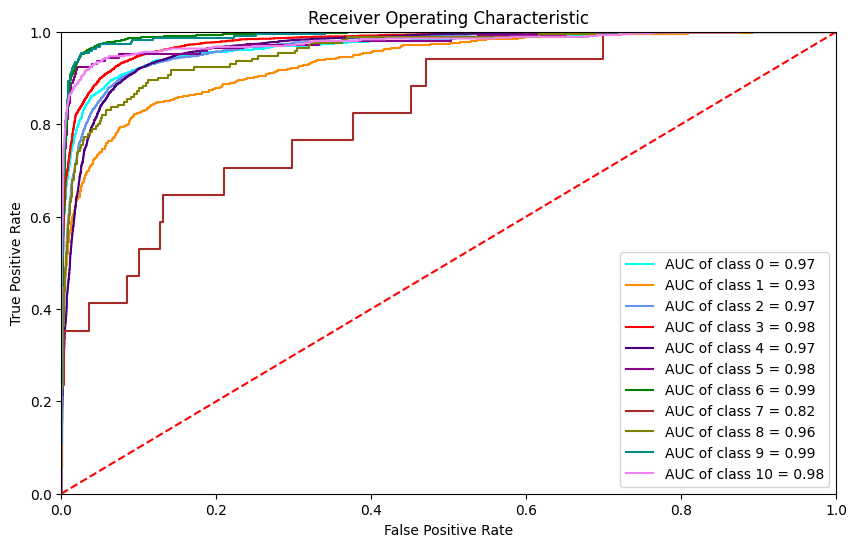

In [83]:
plot_auc(y,colours) 

In [84]:
# open a file where you want to store the data
file = open('customer_classification_model_svm.pkl','wb')
# Dump information to that file
pickle.dump(model, file)